### target prop visualizations

In [2]:
# sigmoid...
%reset -f
%matplotlib inline
import numpy as np  
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns

In [67]:
def square_axes(i=0):
    ''' make axis look nice '''
    fig.axes[i].axhline(0, color='w', linewidth=3.5, alpha=0.25)
    fig.axes[i].axvline(0, color='w', linewidth=3.5, alpha=0.25)
    fig.axes[i].set_xlim(-1.5,1.5)
    fig.axes[i].set_ylim(-1.5,1.5)
    fig.axes[i].set_aspect(1)
    fig.axes[i].get_xaxis().set_ticklabels([])
    fig.axes[i].get_yaxis().set_ticklabels([])

def get_matrix(layer=1):
    if layer == 1:
        np.random.seed(1)
        A = np.array([[2., 0.5],[0.5, 2.]])
        #A = np.random.randn(2,2)
    else:
        np.random.seed(2)
        A = np.array([[2., -0.5],[0.5, 2.]])
        #A = np.random.randn(2,2)
    return A

def get_bias(layer=1):
    if layer == 1:
        np.random.seed(3)
        b = np.array([[-.0],[0.]])
        #b = np.random.randn(2,1)
    else:
        np.random.seed(4)
        b = np.array([[0.],[0.]])
        #b = np.random.randn(2,1)
    return b

def f1(x,layer):
    return np.dot(get_matrix(layer), x) + get_bias(layer)
def f1_inv(x,layer):
    A = get_matrix(layer)
    return np.dot(np.linalg.inv(A), x - get_bias(layer))

def f2(x):
    return 2./(1 + np.exp(-x))-1
def f2_inv(x):
    return -np.log(2./(1+x) - 1)

def df2(x):
    return (1 - f2(x)**2)*x
def df1(x, layer):
    return np.dot(get_matrix(layer).T, x)

def relu(x):
    return x*(x>0)
def drelu(x):
    return int(x>0)

def get_preimg(img, func, eps=0.1):
    """ computes the preimage a of set img through func, i.e.
        img=func(a)"""
    c1 = np.linspace(-2, 2, 201)
    c2 = np.linspace(-2, 2, 201)
    x1, y1 = np.meshgrid(c1, c2)
    a = np.stack((x1.flatten(), y1.flatten()))
    d = np.zeros(a.shape[1])
    b = func(a)
    for i in range(a.shape[1]):
        d[i] = np.min(np.linalg.norm(b[:,i] - img))
    inds = d < eps
    return a[:,inds], b[:,inds]

def get_circle(center, radius, points=100):
    x = radius*np.cos(np.linspace(0, 2*np.pi, num=points)) + center[0]
    y = radius*np.sin(np.linspace(0, 2*np.pi, num=points)) + center[1]
    return np.stack((x,y))

def cross_entropy(y, x):
    return -np.sum(y*np.log(np.exp(x)/np.sum(np.exp(x),axis=0)), axis=0)

def get_ce_grid(y):
    c = np.linspace(-1, 2, 401)
    x1, x2 = np.meshgrid(c, c)
    x_ = np.stack((x1.flatten(), x2.flatten()))
    ce = cross_entropy(y, x_).reshape([401, 401])
    return x1, x2, ce

def prop(init, L=1):
    x = []
    x.append(init)
    for l in range(1, L+1):
        x.append(f1(x[-1], l))
        x.append(f2(x[-1]))
    return x

def back(init, L=1):
    y = []
    y.append(init)
    for l in range(L, 0, -1):
        y.append(f2_inv(y[-1]))
        y.append(f1_inv(y[-1], l))
    y.reverse()
    return y

def bprop(init, L=1):
    d = []
    d.append(init)
    for l in range(L, 0, -1):
        d.append(df2(d[-1]))
        d.append(df1(d[-1], l))
    d.reverse()
    return d


In [68]:
L=2

In [69]:
# Grid lines
c1 = np.linspace(-40, 40, 801)
c2 = np.linspace(-40, 40, 81)
x1, y1 = np.meshgrid(np.append(c1, 999), c2)
x2, y2 = np.meshgrid(np.append(c1, 999), c2)
x1[x1==999] = None
y1[y1==999] = None
x2[x2==999] = None
y2[y2==999] = None

# just grid lines
a1 = prop(np.stack((x1.flatten(), y1.flatten())), L=L)
a2 = prop(np.stack((y2.flatten(), x2.flatten())), L=L)

In [74]:
# Vectors:
x = prop(np.array([[.5],[.5]]), L=L)
y = back(np.array([[0],[0.5]]), L=L)
xt= back(x[-1] - 0.5*(x[-1]-y[-1]), L=L)
dl = bprop(x[-1]-y[-1], L=L)

In [75]:
xce, yce, ce = get_ce_grid(y[-1])

In [76]:
# Shapes:
circ = back(get_circle(y[-1], np.linalg.norm(x[-1] - y[-1])), L=L)
circ2 = back(get_circle(y[-1], 0.5*np.linalg.norm(x[-1] - y[-1])), L=L)
#circ3 = back(get_circle(y[-1], 0.25*np.linalg.norm(x[-1] - y[-1])), L=L)
#circ4 = back(get_circle(y[-1], 0.75*np.linalg.norm(x[-1] - y[-1])), L=L)

ce_ic = back(np.stack((xce.flatten(), yce.flatten())), L=L)

line = back(np.stack((np.linspace(x[-1][0], y[-1][0]), np.linspace(x[-1][1], y[-1][1]))), L=L)

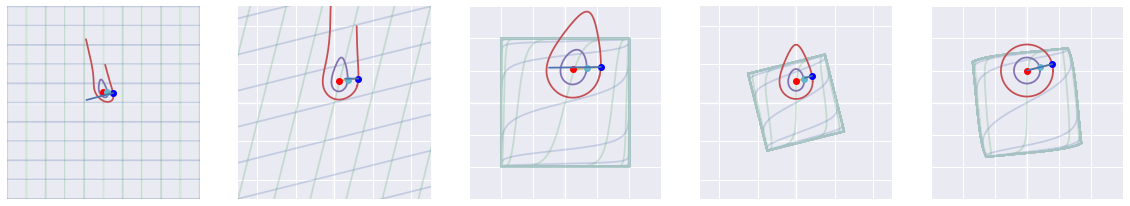

In [77]:
fig, ax = plt.subplots(1, 2*L+1, figsize=(20,20))
for i in range(2*L+1):
    square_axes(i)
    if i % 2 or i == 0:
        fig.axes[i].set_xlim(-5,5)
        fig.axes[i].set_ylim(-5,5)
    
for i in range(2*L+1):
    ax[i].plot(a1[i][0], a1[i][1], '-', alpha=0.25)
    ax[i].plot(a2[i][0], a2[i][1], '-', alpha=0.25)
    ax[i].plot(circ[i][0], circ[i][1])
    ax[i].plot(circ2[i][0], circ2[i][1])
    #ax[i].plot(circ3[i][0], circ3[i][1])
    #ax[i].plot(circ4[i][0], circ4[i][1])
    ax[i].plot(line[i][0], line[i][1])
    ax[i].plot(x[i][0], x[i][1], 'bo')
    ax[i].plot(y[i][0], y[i][1], 'ro')
    ax[i].plot(xt[i][0], xt[i][1], 'o')
    ax[i].plot([x[i][0], x[i][0] - dl[i][0]], [x[i][1], x[i][1] - dl[i][1]])
    #ax[i].contour(ce_ic[i][0].reshape([401, 401]), ce_ic[i][1].reshape([401, 401]), ce, 20)
plt.show()

### vis preimages

In [47]:
def ff(x):
    return f2(f1(x, 1))

In [48]:
aa, bb = get_preimg(np.array([-0.8, 0]), ff, 0.5)

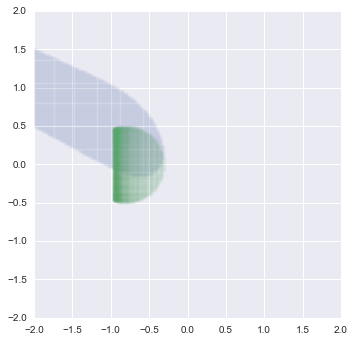

In [34]:
plt.figure()
plt.plot(aa[0,:], aa[1,:], '.', alpha=0.05)
plt.plot(bb[0,:], bb[1,:], '.', alpha=0.05)
plt.axis('square')
plt.xlim([-2,2])
plt.ylim([-2,2])
plt.show()